## Анализ причин оттока клиентов фитнес-центра с помощью машинного обучения

**Описание проекта и его цели.** Я аналитик фитнес-клуба. Основная проблема организации - отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами фитнес-клуба перевёл в электронный вид множество клиентских анкет. Моя задача — провести анализ и подготовить план действий по удержанию клиентов. 
А именно: 
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента; 
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства; 
- проанализировать основные признаки, наиболее сильно влияющие на отток; 
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1. выделить целевые группы клиентов;
2. предложить меры по снижению оттока;
3. определить другие особенности взаимодействия с клиентами.

Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах). \
 \
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

In [21]:
df = pd.read_csv('/.../gym_churn.csv')

In [22]:
df.shape

(4000, 14)

In [23]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Исследовательский анализ данных (EDA)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропущенных значений в полях нет.

In [25]:
# рассмотрим средние значения признаков и стандартные отклонения
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [26]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Средние значения признаков, в зависимости от того, ушел клиент или нет, уже могут рассказать много интересного. В среднем уходят те клиенты, которые: а) не работают в партнерских компаниях, б) берут абонемент на короткий срок, в) меньше посещают групповые занятия, г) имеют небольшой период посещения спортзала, д) за последний месяц посещали спортзал всего 1 раз в неделю.

In [27]:
# Разделяем данные на две группы - отток и оставшиеся
churn= df[df['Churn'] == True]
not_churn = df[df['Churn'] == False]

In [28]:
#выделим датасет с признаками
features = df.drop('Churn', axis = 1)

Построим гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).


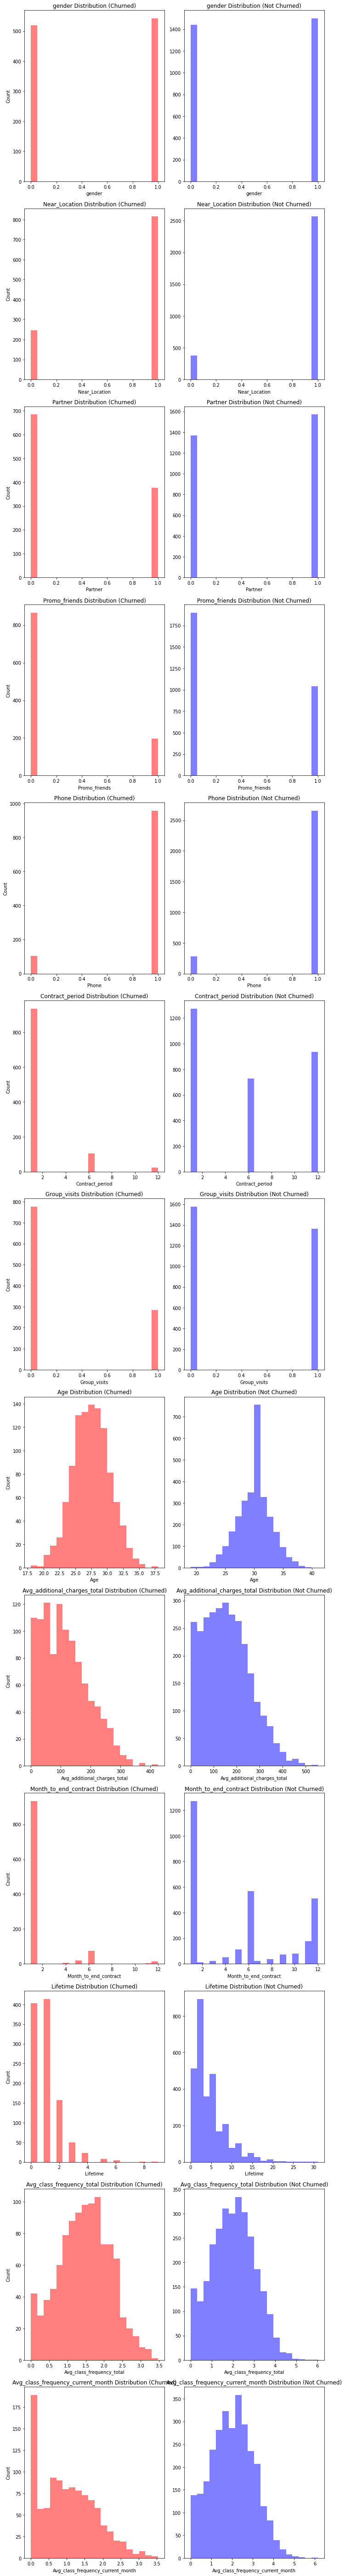

In [29]:
fig, axes = plt.subplots(len(features.columns), 2, figsize=(10, 6 * len(features.columns)))
for i, feature in enumerate(features.columns):
    # Столбчатая гистограмма для оттока
    ax1 = axes[i, 0]
    ax1.hist(churn[feature], bins=20, color='red', alpha=0.5)
    ax1.set_title(f'{feature} Distribution (Churned)')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Count')

    # Столбчатая гистограмма для оставшихся
    ax2 = axes[i, 1]
    ax2.hist(not_churn[feature], bins=20, color='blue', alpha=0.5)
    ax2.set_title(f'{feature} Distribution (Not Churned)')
    ax2.set_xlabel(feature)
plt.tight_layout()
plt.show()

Данные из гистрограмм в целом подверждают промежуточные выводы из анализа средних значений. В наибольшей степени между двумя группами различаются следующие признаки: длительность абонемента, является ли сотрудником партнера, групповые визиты, количество посещений в месяц.

In [30]:
#составим матрицу корреляций
cm = df.corr()

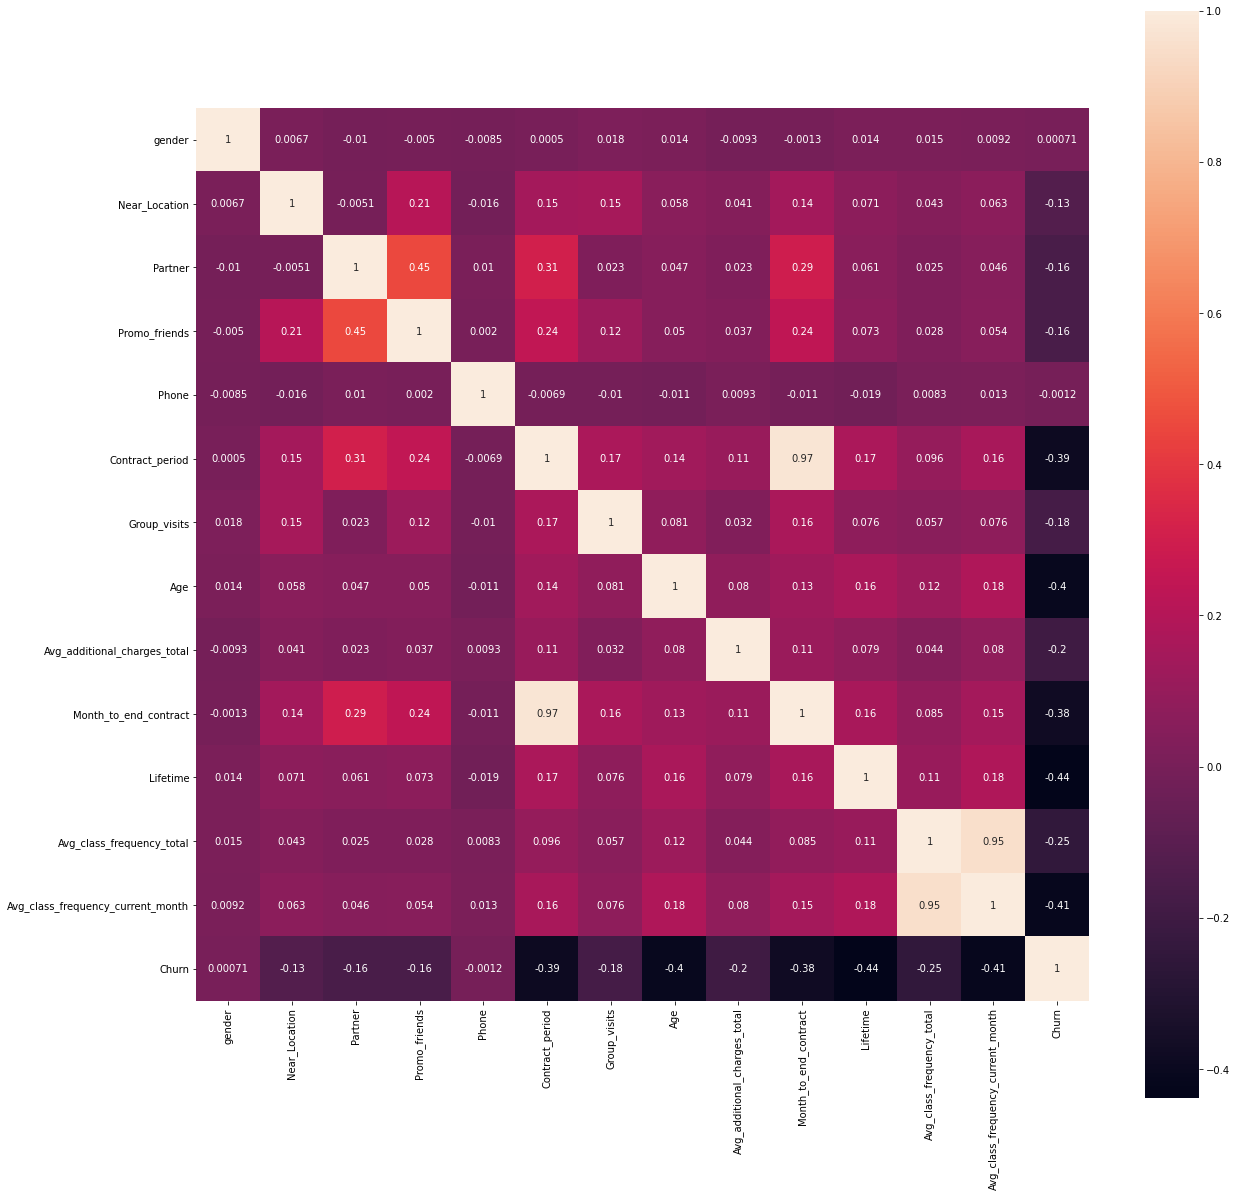

In [31]:
# вызуализируем матрицу с помощью хитмэпа
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cm, annot=True, square=True)
plt.show()

У большинства признаков наблюдается умеренная отрицательная корреляция с целевой переменной, что хорошо, значит, связь между ними с большой долей вероятности присутствует. Практически нулевая корелляция есть только у пола клиентов. Между некоторыми признаками есть очень высокая корреляция. Например между количеством месяцев до конца абонемента и длительностью абонемента - 97%, и между средним количеством посещений в неделю за весь период и за последний месяц - 95%. Данные признаки действительно выглядят достаточно схожими.

**Выводы:** исследовательский анализ данных показал, что часть признаков действительно отличаются между группами и наблюдается отрицательная корреляционная связь у большей части признаков с целевой переменной. Ряд признаков имеют высокую взаимную корреляцую. 

Удалим поле "среднее посещение фитнес-центра в неделю", так как мы видим значительную взаимную корреляцию со "средним посещением фитнес-центра в неделю", но при этом у последнего корреляция с нашей целевой переменной выше. Также удалим поле с "количеством месяцев до окончания действия контракта" по аналогичной причине: данный показатель сильно коррелирует с "периодом действия контракта".

In [32]:
df = df.drop(columns=['Month_to_end_contract', 'Avg_class_frequency_total'])

## Модель прогнозирования оттока клиентов

In [35]:
# прочитаем из csv-файла данные о параметрах сетей и их устойчивости
electrical_grid = pd.read_csv(
    '/datasets/Electrical_Grid_Stability.csv', sep=';'
)
print('Размер датасета:', electrical_grid.shape)
electrical_grid.head()

# посмотрим, как соотносятся классы для нашего набора данных
electrical_grid['stability'].value_counts()

# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = electrical_grid.drop('stability', axis=1)
y = electrical_grid['stability']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для нашей модели
model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:, 1]

# выведем все изученные метрики
print('Метрики для логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}\n'.format(roc_auc_score(y_test, probabilities)))

# зададим алгоритм для новой модели на основе алгоритма решающего дерева
tree_model = DecisionTreeClassifier(random_state=0)

# обучите модель
tree_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
tree_predictions = tree_model.predict(X_test)
tree_probabilities = tree_model.predict_proba(X_test)[:, 1]

# выведем все изученные метрики
print('Метрики для дерева принятия решения')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, tree_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, tree_probabilities)))

Размер датасета: (10000, 13)
Метрики для логистической регрессии
Accuracy: 0.81
Precision: 0.77
Recall: 0.70
F1: 0.73
ROC_AUC: 0.89

Метрики для дерева принятия решения
Accuracy: 0.83
Precision: 0.77
Recall: 0.77
F1: 0.77
ROC_AUC: 0.82


Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [36]:
#выгрузим все необходимые модули
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score


In [37]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

In [38]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [39]:
# стандартизируем данные, обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [40]:
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [41]:
# зададим алгоритм для нашей модели, используя логистическую регрессию
model = LogisticRegression(solver='liblinear', random_state=0)

In [42]:
# обучим модель
model.fit(X_train_st, y_train)


LogisticRegression(random_state=0, solver='liblinear')

In [43]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:, 1]

In [44]:
# выведем метрики
print('Метрики для логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Метрики для логистической регрессии
Accuracy: 0.90
Precision: 0.79
Recall: 0.82
F1: 0.81


In [45]:
model.coef_ 

array([[ 0.04977062, -0.08209208, -0.06898402, -0.23832705, -0.08553054,
        -1.3134245 , -0.37132153, -1.08571942, -0.57137833, -3.80526342,
        -1.30355471]])

In [47]:
coef = pd.Series(model.coef_[0])
coef

0     0.049771
1    -0.082092
2    -0.068984
3    -0.238327
4    -0.085531
5    -1.313425
6    -0.371322
7    -1.085719
8    -0.571378
9    -3.805263
10   -1.303555
dtype: float64

In [48]:
X.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Lifetime',
       'Avg_class_frequency_current_month'],
      dtype='object')

In [49]:
#Посмотрим, какие признаки модель посчитала самыми значимыми
importances_regression = pd.DataFrame({'Признаки': X.columns, 'Важность': abs(coef) })
importances_regression.sort_values(by='Важность', ascending=False)

,Признаки,Важность
9,Lifetime,3.805263
5,Contract_period,1.313425
10,Avg_class_frequency_current_month,1.303555
7,Age,1.085719
8,Avg_additional_charges_total,0.571378
6,Group_visits,0.371322
3,Promo_friends,0.238327
4,Phone,0.085531
1,Near_Location,0.082092
2,Partner,0.068984


In [50]:
# зададим алгоритм для новой модели на основе алгоритма решающего дерева
tree_model = DecisionTreeClassifier(random_state=0)

In [51]:
# обучите модель
tree_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=0)

In [52]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
tree_predictions = tree_model.predict(X_test)
tree_probabilities = tree_model.predict_proba(X_test)[:, 1]

In [53]:
# выведем метрики
print('Метрики для дерева принятия решения')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, tree_predictions)))

Метрики для дерева принятия решения
Accuracy: 0.86
Precision: 0.69
Recall: 0.77
F1: 0.73


In [54]:
#Посмотрим, какие признаки модель посчитала самыми значимыми
importances = pd.DataFrame({'Признаки': X.columns, 'Важность': tree_model.feature_importances_})

print(importances.sort_values(by='Важность', ascending=False))


                             Признаки  Важность
9                            Lifetime  0.374122
10  Avg_class_frequency_current_month  0.208160
8        Avg_additional_charges_total  0.137582
5                     Contract_period  0.118164
7                                 Age  0.100005
3                       Promo_friends  0.014953
0                              gender  0.014221
6                        Group_visits  0.014080
1                       Near_Location  0.008536
2                             Partner  0.006928
4                               Phone  0.003248


Попробуем также попробовать другие модели: случайный лес и градиентный бустинг

In [55]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [56]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)


In [57]:
# выведем метрики
print('Метрики для случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Метрики для случайного леса
Accuracy: 0.90
Precision: 0.81
Recall: 0.75
F1: 0.78


In [58]:
#Посмотрим, какие признаки модель посчитала самыми значимыми
importances = pd.DataFrame({'Признаки': X.columns, 'Важность': rf_model.feature_importances_})

print(importances.sort_values(by='Важность', ascending=False))


                             Признаки  Важность
9                            Lifetime  0.321261
10  Avg_class_frequency_current_month  0.216309
7                                 Age  0.138439
8        Avg_additional_charges_total  0.123375
5                     Contract_period  0.110949
6                        Group_visits  0.020262
0                              gender  0.016636
2                             Partner  0.016403
3                       Promo_friends  0.016031
1                       Near_Location  0.012050
4                               Phone  0.008287


In [59]:
# сделаем все то же самое для алгоритма градиентного бустинга
gb_model = GradientBoostingClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
gb_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
gb_predictions = gb_model.predict(X_test_st)

In [60]:
# выведем метрики
print('Метрики для градиентного бустинга')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, gb_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, gb_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, gb_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, gb_predictions)))

Метрики для градиентного бустинга
Accuracy: 0.90
Precision: 0.81
Recall: 0.77
F1: 0.79


In [61]:
#Посмотрим, какие признаки модель посчитала самыми значимыми
importances = pd.DataFrame({'Признаки': X.columns, 'Важность': gb_model.feature_importances_})

print(importances.sort_values(by='Важность', ascending=False))


                             Признаки  Важность
9                            Lifetime  0.521182
10  Avg_class_frequency_current_month  0.164750
5                     Contract_period  0.151271
7                                 Age  0.109733
8        Avg_additional_charges_total  0.040492
6                        Group_visits  0.007185
3                       Promo_friends  0.003531
1                       Near_Location  0.001368
0                              gender  0.000276
2                             Partner  0.000132
4                               Phone  0.000079


**Вывод**: Обычная логистическая регрессия показала себя в среднем лучше, чем остальные модели. При этом все модели посчитали важными практически одни и те же признаки: время с момента первого обращения в фитнес-центр, средняя частота посещений за последний месяц, длительность абонемента. Причем градиентный бустинг посчитал, что почти половина изменичивости целевой переменной приходится на время с момента первого обращения в фитнес-центр.  Незначительными оказались наличие телефона, пол, расположение дома, работа в компании партнера. Последнее является неочевидным, так как на графиках явно была замента разница в этом показателе между двумя группами. Интересно, что этот показатель логистическая регрессия оценила хоть и низко, но все равно значительно выше, чем другие алгоритмы.

## Кластеризация клиентов

In [62]:
#стандартизируем все данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Сначала построим матрицу расстояний и нарисуем дендрограмму. 

In [63]:
from scipy.cluster.hierarchy import dendrogram, linkage 

In [64]:
linked = linkage(X_sc, method = 'ward') 

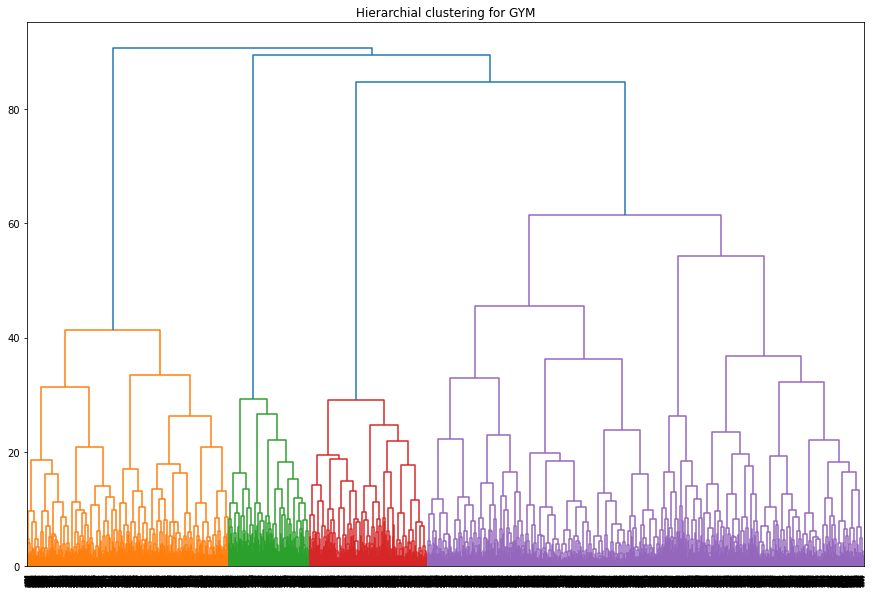

In [65]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

Предложенное оптимальное число кластеров - 4.

Кластеризуем клиентов через алгоритм k-means.

In [66]:
from sklearn.cluster import KMeans

In [67]:
km = KMeans(n_clusters=5, random_state=0) # количество кластеров - 5, так как это требуется по заданию.
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [68]:
#добавим столбец с кластерами в датасет
X['clusters'] = labels

In [69]:
#посмотрим на средние значения признаков по кластерам
X.groupby('clusters').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month
clusters,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967


Из анализа средних значений признаков сразу видно, что пол и возраст не послужили ключевыми признаками, по которым произошла кластеризация. Видно, что первый кластер это те пользователи, которые не оставили телефон, так как средний показатель данного признака - 0. Второй кластер - это те, кто живут далеко от фитнес центра, так как среднее данного показателя также равно 0. Третий кластер - наоборот те, кто живут у фитнес-центра, так как этот показтель равен 1. В нулевой кластер входят клиенты с самым длительным периодом действия абонемента. Также у этого класса самое высокое значение признака "partner" и "promo_friends", таким образом, эти пользователи в наибольшей степени интегрированы с фитнес центром, через дительность абонемента, работу или друзей. В последний четвертый кластер входят наиболее активные посетители фитнес-центра. В отличие от нулевого кластера, у них меньший срок абонемента, и не такая высокая доля признаков "partner" и "promo_friends", однако частота походов в зал очень высокая - в среднем около 3 раз в неделю.

In [70]:
cluster_0 = X[X['clusters'] == 0]
cluster_1 = X[X['clusters'] == 1]
cluster_2 = X[X['clusters'] == 2]
cluster_3 = X[X['clusters'] == 3]
cluster_4 = X[X['clusters'] == 4]

In [75]:
X.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Lifetime',
       'Avg_class_frequency_current_month', 'clusters'],
      dtype='object')

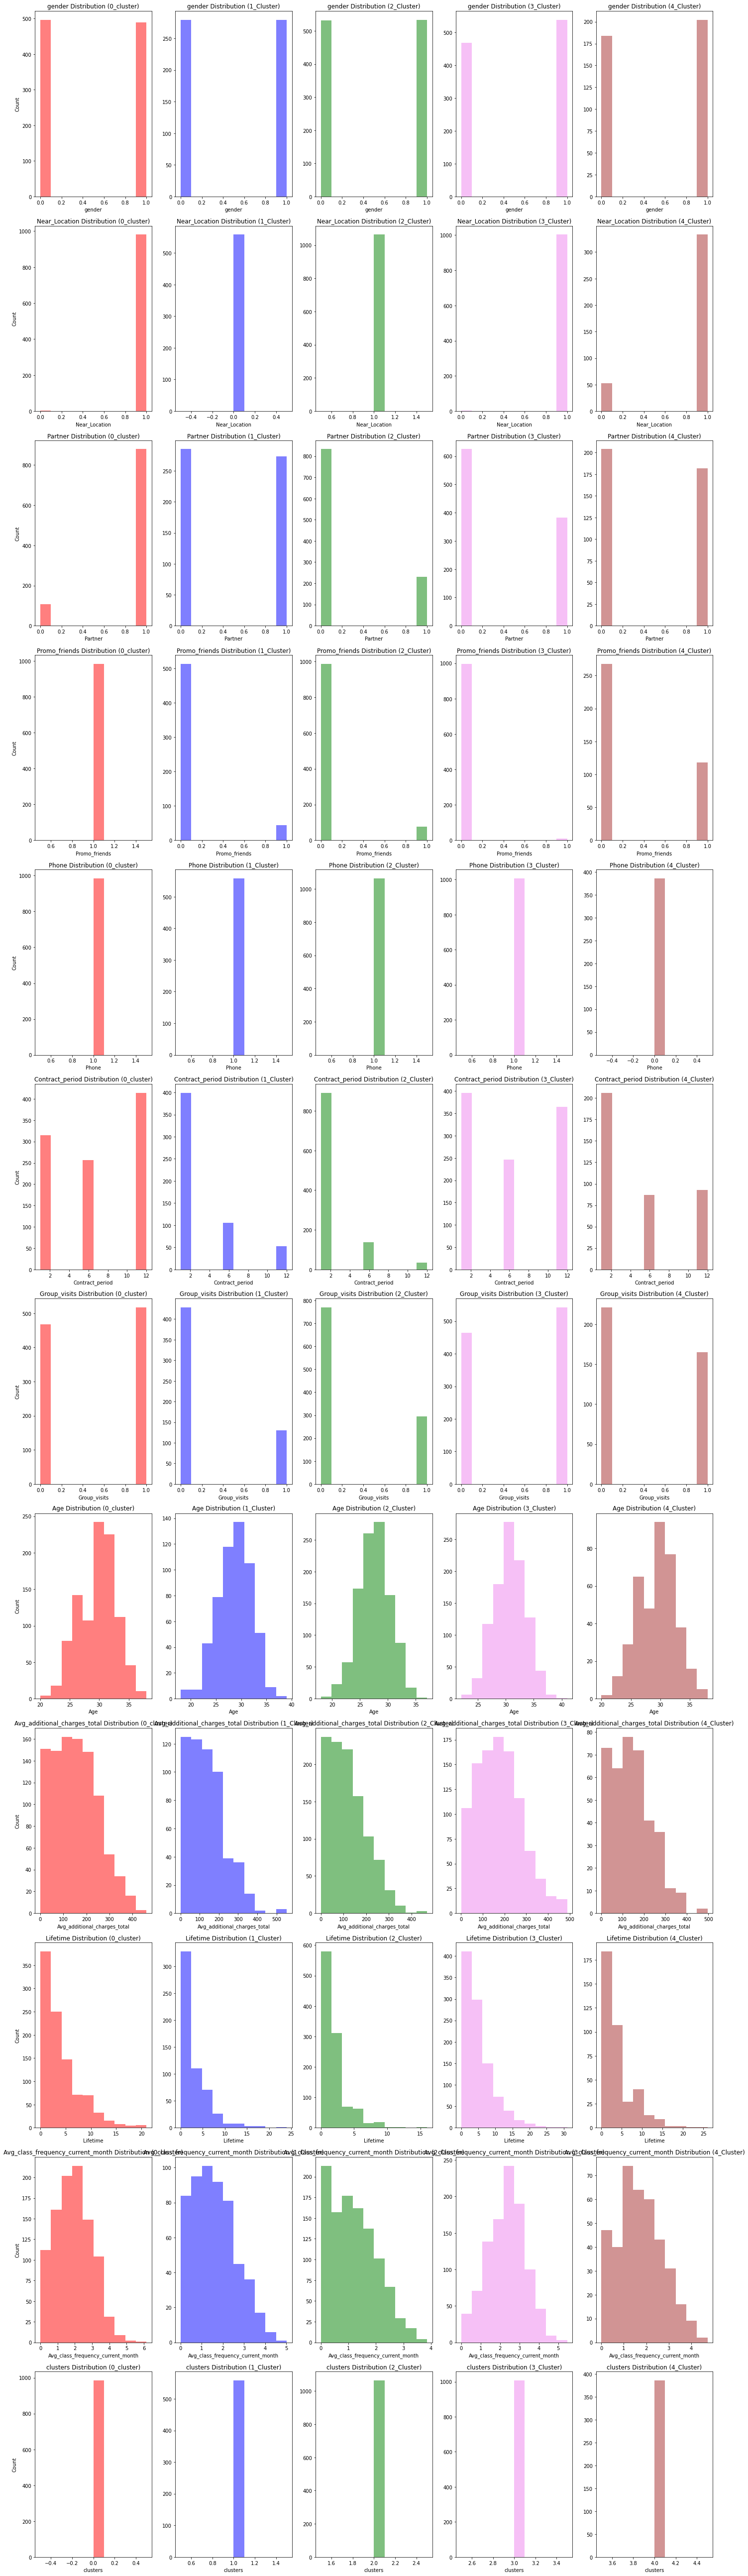

In [76]:
fig, axes = plt.subplots(len(X.columns), 5, figsize=(20, 6 * len(X.columns)))
for i, feature in enumerate(X.columns):
    # Столбчатая гистограмма для 0 кластера
    ax1 = axes[i, 0]
    ax1.hist(cluster_0[feature], bins=10, color='red', alpha=0.5)
    ax1.set_title(f'{feature} Distribution (0_cluster)')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Count')

    # Столбчатая гистограмма для 1 кластера
    ax2 = axes[i, 1]
    ax2.hist(cluster_1[feature], bins=10, color='blue', alpha=0.5)
    ax2.set_title(f'{feature} Distribution (1_Cluster)')
    ax2.set_xlabel(feature)
    
    # Столбчатая гистограмма для 2 кластера
    ax3 = axes[i, 2]
    ax3.hist(cluster_2[feature], bins=10, color='green', alpha=0.5)
    ax3.set_title(f'{feature} Distribution (2_Cluster)')
    ax3.set_xlabel(feature)
    
    # Столбчатая гистограмма для 3 кластера
    ax4 = axes[i, 3]
    ax4.hist(cluster_3[feature], bins=10, color='violet', alpha=0.5)
    ax4.set_title(f'{feature} Distribution (3_Cluster)')
    ax4.set_xlabel(feature)
    
     # Столбчатая гистограмма для 4 кластера
    ax5 = axes[i, 4]
    ax5.hist(cluster_4[feature], bins=10, color='brown', alpha=0.5)
    ax5.set_title(f'{feature} Distribution (4_Cluster)')
    ax5.set_xlabel(feature)
    
plt.tight_layout()
plt.show()

Графики распределения признаков подтвердили предыдущие тезисы по кластерам. Вообще бизнесу не нужны кластеры, которые образовались только по признаку наличия телефонов или удаленности от места жительства, так как эти переменные практически не влияют на то, уйдет клиент из фитнес-центра или нет, как мы убедились в части проекта с бинарной классификацией. Поэтому попробуем удалить данные признаки и составить еще одну кластеризацию уже без них. Также лучше удалить другие бинарные признаки, так как в модели они не имеют большого значения и при этом они "перетягивают" на себя кластеры при кластеризации. Попытаемся провести кластеризацию на небинарных признаках.

In [77]:
X_new = X.drop(['Phone', 'Near_Location', 'Partner', 'gender', 'Group_visits', 'Promo_friends'], axis=1)

In [78]:
#стандартизируем все данные
sc = StandardScaler()
X_sc_new = sc.fit_transform(X_new)

In [79]:
km = KMeans(n_clusters=5, random_state=0) # количество кластеров - 5, так как это требуется по заданию.
labels = km.fit_predict(X_sc_new) # применяем алгоритм к данным и формируем вектор кластеров 

In [80]:
X_new['clusters'] = labels

In [81]:
#посмотрим на средние значения признаков по кластерам
X_new.groupby('clusters').mean()

,Contract_period,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month
clusters,,,,,
0,1.330375,31.249507,154.019664,3.224852,2.224220
1,9.825073,30.053936,173.501555,3.715743,2.127102
2,4.250000,29.564935,150.646727,13.035714,2.067372
3,9.844950,29.854908,162.058573,4.179232,2.058057
4,1.866563,26.640031,118.115234,1.650116,0.985331


In [82]:
cluster_0 = X_new[X_new['clusters'] == 0]
cluster_1 = X_new[X_new['clusters'] == 1]
cluster_2 = X_new[X_new['clusters'] == 2]
cluster_3 = X_new[X_new['clusters'] == 3]
cluster_4 = X_new[X_new['clusters'] == 4]

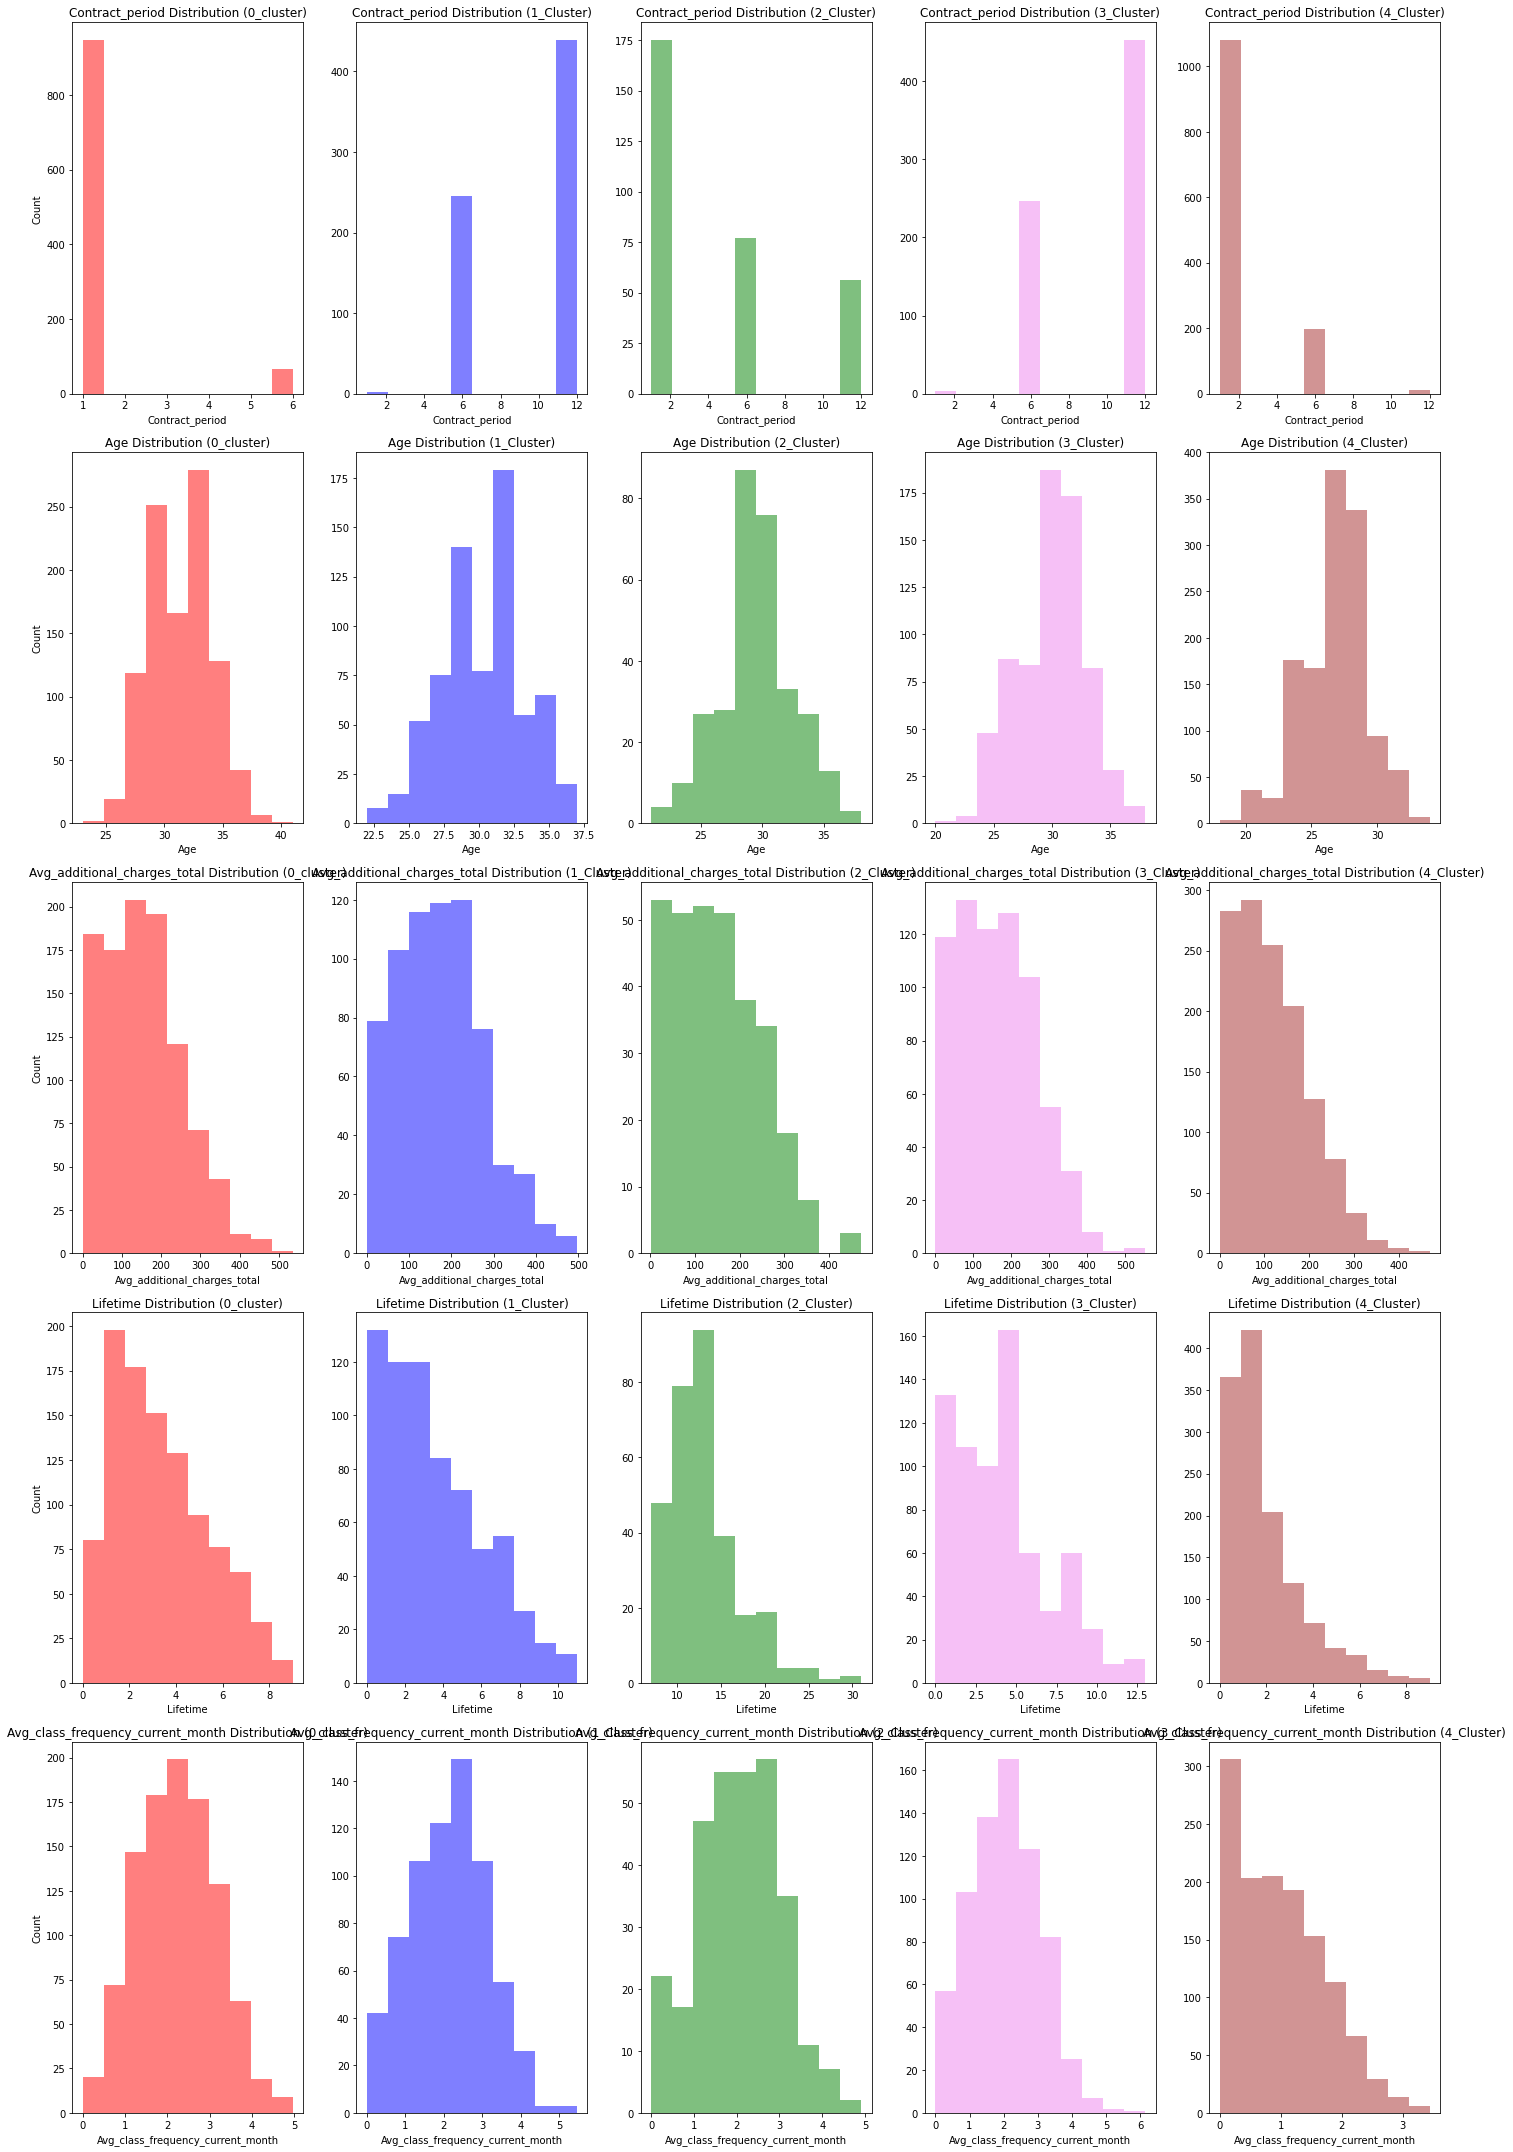

In [83]:
fig, axes = plt.subplots(len(X_new.drop('clusters', axis=1).columns), 5,
                         figsize=(20, 6 * len(X_new.drop('clusters', axis=1).columns)))
for i, feature in enumerate(X_new.drop('clusters', axis=1).columns):
    # Столбчатая гистограмма для 0 кластера
    ax1 = axes[i, 0]
    ax1.hist(cluster_0[feature], bins=10, color='red', alpha=0.5)
    ax1.set_title(f'{feature} Distribution (0_cluster)')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Count')

    # Столбчатая гистограмма для 1 кластера
    ax2 = axes[i, 1]
    ax2.hist(cluster_1[feature], bins=10, color='blue', alpha=0.5)
    ax2.set_title(f'{feature} Distribution (1_Cluster)')
    ax2.set_xlabel(feature)
    
    # Столбчатая гистограмма для 2 кластера
    ax3 = axes[i, 2]
    ax3.hist(cluster_2[feature], bins=10, color='green', alpha=0.5)
    ax3.set_title(f'{feature} Distribution (2_Cluster)')
    ax3.set_xlabel(feature)
    
    # Столбчатая гистограмма для 3 кластера
    ax4 = axes[i, 3]
    ax4.hist(cluster_3[feature], bins=10, color='violet', alpha=0.5)
    ax4.set_title(f'{feature} Distribution (3_Cluster)')
    ax4.set_xlabel(feature)
    
     # Столбчатая гистограмма для 4 кластера
    ax5 = axes[i, 4]
    ax5.hist(cluster_4[feature], bins=10, color='brown', alpha=0.5)
    ax5.set_title(f'{feature} Distribution (4_Cluster)')
    ax5.set_xlabel(feature)
    
plt.tight_layout()
plt.show()

Данная кластеризация выглядит более оптимальной. 1 и 3 кластеры похожи: они включают в себя клиентов с самой большой продолжительностью абонемента (в среднем - год), которые регулярно ходят в фитнес-центр (около 2-3 раз в неделю). Есть небольшое отличие в том, что у 3 класса немного более "старые" клиенты, которые немного меньше тратят деньги на дополнительные услуги чуть-чуть меньше ходят.  0 кластер - клиенты, которые также часто ходят в фитнес, но предпочитают более короткий срок абонемента (в среднем - 2-3 месяца). 4 кластер включает в себя клиентов, у которых и абонементы короткие, и ходят они редко, и они при этом являются новичками в фитнес-центре. 2 кластер объединяет в себе ветеранов: у них самое длительное время с момента первого посещения фитнес-центра. При этом у них достаточно умеренные сроки абонементов и количество походов в фитнес-центр в неделю.

In [84]:
#Посмотрим как распределена по кластерам доля клиентов, которая считается выбывшей
df['clusters'] = X_new['clusters']
df.groupby('clusters')['Churn'].mean()

clusters
0    0.132150
1    0.026239
2    0.000000
3    0.022760
4    0.692785
Name: Churn, dtype: float64

Статистика оказалась интересной. Кастер "долгожителей" оказался самым устойчивым к оттоку. Также хорошее значение около 2-3% выбывших показал 1 и 3 кластер, где у клиентов самые длительные абонементы. Ощутимая доля выбывших - 13,2% у 1 кластера, который объединяет в себе клиентов, которые часто ходят, но у них короткий срок абонемента. Скорее всего такие клиенты быстро выгорают, и часть из них "отпадает" из-за этого. Ну и самый ненадежный кластер, с долей 69% выбывших, - 4, который состоит из клиентов, которые имеют короткий абонемент и которые при этом ходят редко.

In [85]:
#посмотрим, как распределены кластеры количественно по клиентам
cluster_counts = df.groupby('clusters')['Contract_period'].count()
total_clients = cluster_counts.sum()
cluster_ratios = cluster_counts / total_clients
cluster_group = pd.DataFrame({'Количество клиентов': cluster_counts, 'Доля клиентов': cluster_ratios})
cluster_group 

,Количество клиентов,Доля клиентов
clusters,,
0,1014,0.25350
1,686,0.17150
2,308,0.07700
3,703,0.17575
4,1289,0.32225


Как выяснилось, "ненадежный" кластер при этом является самым многочисленным, к нему принадлежат 32% всех клиентов. Еще 25% клиентов относятся 1 кластеру, куда входят клиенты с небольшим сроком абонемента, но активно посещающие спортзал, которые также являются в группе риска. 

**Вывод:** кластеризация с учетом избавления от части признаков, которые создавали большой шум, позволила выделить несколько групп клиентов с совершенно разным поведением и "надежностью". Машинное обучение без учителя смогло выявить кластер, где большинство клиентов являются "выбывшими", а также другие кластеры, где доля таких клиентов минимальна.

## Выводы и рекомендации

1. Самым важным признаком, который влияет на сохранение пользователей, является время с момента их первого посещения фитнес-центра. Кластеризация выделила ядро наиболее лояльный пользователей (около 7% от общего числа), которые являются старыми клиентами и которые скорее всего не бросят ходить в фитнес центр. Они ходят стабильно, хоть и не так часто, как самое активное крыло. Таких клиентов нужно беречь, так как они стабильно генерируют денежный поток для компании. Поэтому за показателем удержания данных пользователей нужно следить и в случае если он начнет падать, связываться с такими клиентами и, возможно, предлагать им более лояльные условия. Также уменьшение данного кластера может свидетельствовать о самых негативных тенденциях бизнеса, так как уходят самые лояльные клиенты.
2. Другим признаком, который оказался важным, является длительность абонемента. Клиенты, которые купили себе абонементы на полгода или на год склонны не бросять походы в фитнес-центр. Поэтому в качестве маркетинговой стратегии можно предложить увеличить долю таких клиентов путем введения акций на долгосрочные абонементы с возможным обзвоном или рассылкой предложений тем клиентам, которые купили абонементы на короткий срок. Если получилось завлечь клиентов на долгосрочный абонемент, то уже даже не так важен факт регулярного посещения фитнес центра. При кластеризации выделился отдельный такой кластер, у клиентов которого долгосрочные абонементы, но при этом ходят они не так часто в фитнес-зал. При этом доля оттока среди этого кластера незначительная.
3. Также значимым признаком является количество посещений спортзала в неделю. Модели классификации в большинстве своем вывели значимость этого признака на 2 место после продолжительности походов в фитнес-центр. Действительно, самыс ненадежным кластером оказался кластер, где клиенты покупали себе краткосрочные абонементы и ходили в спортзал редко, и у них не успевала выработаться привычка регулярно посещать фитнес-центры. Также не стоит забывать про достаточно большой кластер людей, которые очень активно ходили, но при этом покупали краткосрочные абонементы, и среди них отток тоже достаточно большой. Я предполагаю, что это связано с выгоранием, и опять же с тем, что привычка не успела сформироваться и люди бросали заниматься спортом. Поэтому решение этой проблемы быть в увеличении доли занятий на регулярной основе будь то групповые занятия или индивидуальные занятия с тренером. Необходимо быть на контакте с такими людьми, у которых еще не сформировалась привычка посещения фитнес-центра, и предлагать им различные регулярные занятия.